# LoadData
## MNIST

torch.Size([64, 1, 28, 28])


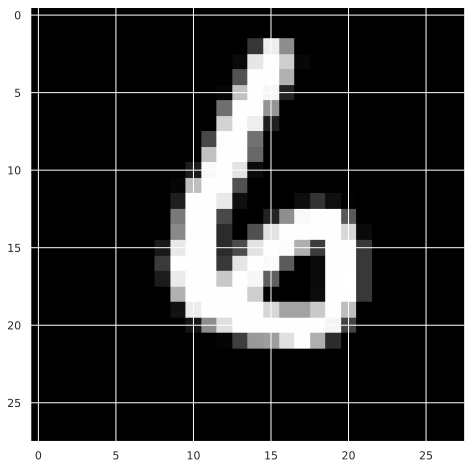

In [117]:
from torchvision import datasets, transforms
import torch.utils.data as dset
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),]
)


trainSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
testSet = datasets.MNIST(root='MNIST', download=True, train=False, transform=transform)
trainLoader = dset.DataLoader(trainSet, batch_size=64, shuffle=True)
testLoader = dset.DataLoader(testSet, batch_size=64, shuffle=False)

for data, targets in trainLoader:
    break
print(data.shape)
plt.imshow(data[5,0,:,:]*255)
plt.show()

## FashionMNIST

torch.Size([64, 1, 28, 28])


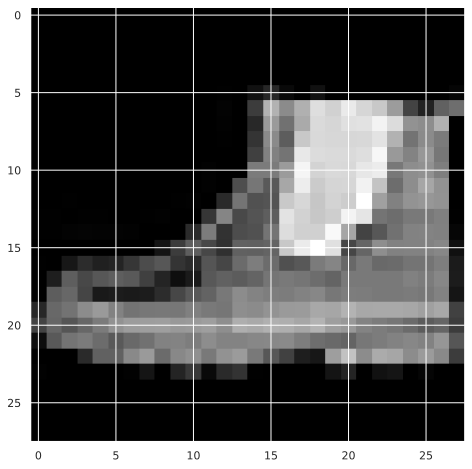

In [118]:
trainSet = datasets.FashionMNIST(root='FashionMNIST', download=True, train=True, transform=transform)
testSet = datasets.FashionMNIST(root='FashionMNIST', download=True, train=False, transform=transform)
trainLoader = dset.DataLoader(trainSet, batch_size=64, shuffle=True)
testLoader = dset.DataLoader(testSet, batch_size=64, shuffle=False)

for data, targets in trainLoader:
    break
print(data.shape)
plt.imshow(data[5,0,:,:]*255)
plt.show()

## Model

In [119]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import numpy as np
import torchvision.utils as vutils
import PIL.Image as Image

# Model structure
class Encoder(nn.Module):
    def __init__(self,latent_dim : int):
        super(Encoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, latent_dim),
            nn.Tanh()
        )
    def forward(self, inputs):
        codes = self.encoder(inputs)
        return codes
class Decoder(nn.Module):
    def __init__(self,latent_dim : int):
        super(Decoder, self).__init__()
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )
    def forward(self, inputs):
        outputs = self.decoder(inputs)
        return outputs

class AutoEncoder(nn.Module,):
    def __init__(self,latent_dim : int):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = Encoder(latent_dim)
        # Decoder
        self.decoder = Decoder(latent_dim)
        


    def forward(self, inputs):
        codes = self.encoder(inputs)
        decoded = self.decoder(codes)
        return codes, decoded

## MNIST latent dim = 64,32,4 training and testing MSE 

In [120]:
epochs = 20
batch_size = 64
lr = 0.001
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
train_loader = DataLoader(datasets.MNIST('./MNIST', train=True, download=False, transform=transforms.ToTensor()), 
                          batch_size=batch_size, 
                          shuffle=True)
test_loader = DataLoader(datasets.MNIST('./MNIST', train=True, download=False, transform=transforms.ToTensor()), 
                          batch_size=batch_size, 
                          shuffle=True)
                          
latent_dim_list = [64,32,4]
model_ae = [0 for i in range(len(latent_dim_list))]
for i in range(len(latent_dim_list)):
    model_ae[i] = AutoEncoder(latent_dim_list[i]).to(device)
    optimizer = torch.optim.Adam(model_ae[i].parameters(), lr=lr)
    loss_function = nn.MSELoss().to(device)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,40], gamma=0.5)

In [121]:
for i in range(len(latent_dim_list)):
    # Train
    log_loss=[]
    model_ae[i].train()
    for epoch in range(epochs):
        total_loss = 0
        
        for data, _ in train_loader:
            inputs = data.view(-1, 784).to(device) 
            model_ae[i].zero_grad()
            # Forward
            codes, decoded = model_ae[i](inputs)
            loss = loss_function(decoded, inputs)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            log_loss.append(loss)
        total_loss /= len(train_loader.dataset)
        scheduler.step()

        # Test
        model_ae[i].eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                inputs = data.view(-1, 784).to(device)
                codes, decoded = model_ae[i](inputs)
                test_loss = loss_function(decoded, inputs)
                
        
        if epoch % 5 ==0:
            print('latent_dim',latent_dim_list[i],'[{}/{}] Train MSELoss:'.format(epoch+1, epochs), total_loss.item())
            print('latent_dim',latent_dim_list[i],'[{}/{}] Test MSELoss:'.format(epoch+1, epochs), test_loss.item())

        
    print('latent_dim',latent_dim_list[i],'[{}/{}] MSELoss:'.format(epoch+1, epochs), total_loss.item())
    print('latent_dim',latent_dim_list[i],'[{}/{}] Test MSELoss:'.format(epoch+1, epochs), test_loss.item())
    print('-----------------------------------------------------------------------------')
    # plt.plot(log_loss)
    torch.save(model_ae[i], 'AutoEncoder_MNIST'+str(latent_dim_list[i])+'MSE.pth')

    

latent_dim 64 [1/20] Train MSELoss: 0.0036269482225179672
latent_dim 64 [1/20] Test MSELoss: 0.2309054434299469
latent_dim 64 [6/20] Train MSELoss: 0.003626972669735551
latent_dim 64 [6/20] Test MSELoss: 0.23342806100845337
latent_dim 64 [11/20] Train MSELoss: 0.0036269694101065397
latent_dim 64 [11/20] Test MSELoss: 0.23212778568267822
latent_dim 64 [16/20] Train MSELoss: 0.0036269526463001966
latent_dim 64 [16/20] Test MSELoss: 0.23007555305957794
latent_dim 64 [20/20] MSELoss: 0.0036269580014050007
latent_dim 64 [20/20] Test MSELoss: 0.23181578516960144
-----------------------------------------------------------------------------
latent_dim 32 [1/20] Train MSELoss: 0.003618130460381508
latent_dim 32 [1/20] Test MSELoss: 0.230898916721344
latent_dim 32 [6/20] Train MSELoss: 0.0036181225441396236
latent_dim 32 [6/20] Test MSELoss: 0.232831671833992
latent_dim 32 [11/20] Train MSELoss: 0.003618120914325118
latent_dim 32 [11/20] Test MSELoss: 0.2303876280784607
latent_dim 32 [16/20] Tra

## Show 16 reconstructed image for 16 random images from training dataset as a 4x4 grid

training dataset Original Images


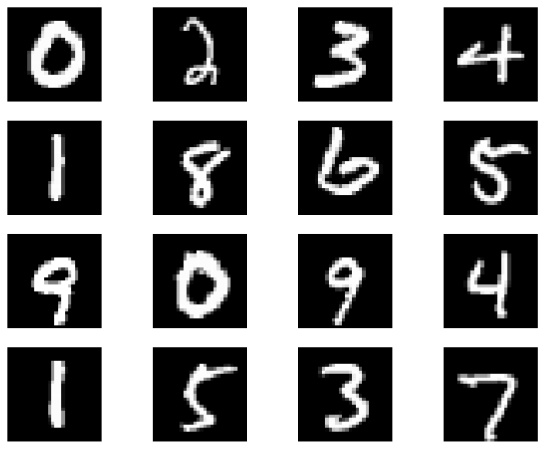

training dataset Restructured Image by AE latent_dim 64 MSE


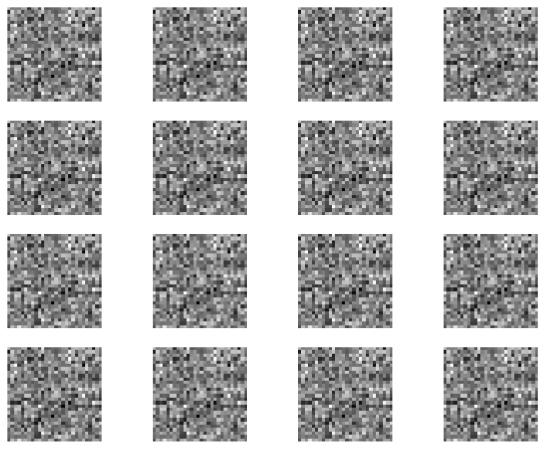

training dataset Original Images


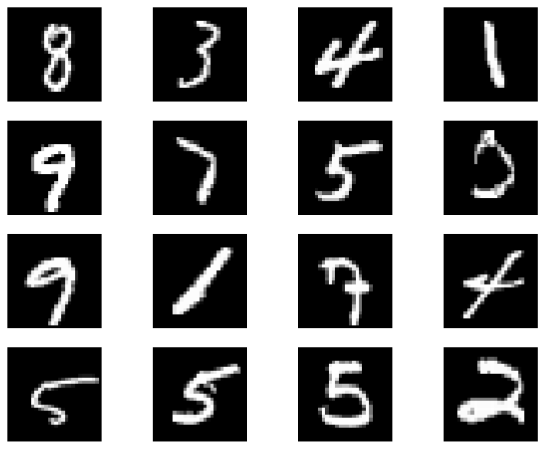

training dataset Restructured Image by AE latent_dim 32 MSE


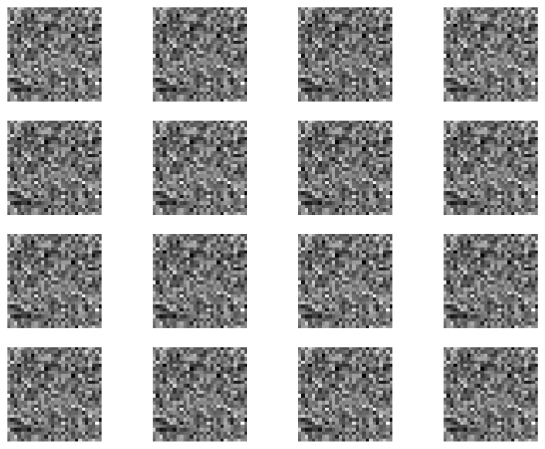

training dataset Original Images


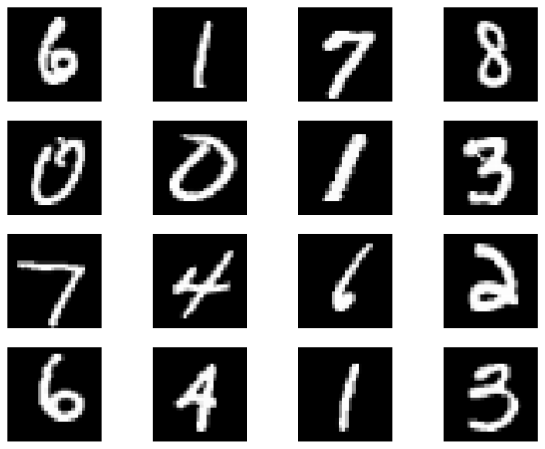

training dataset Restructured Image by AE latent_dim 4 MSE


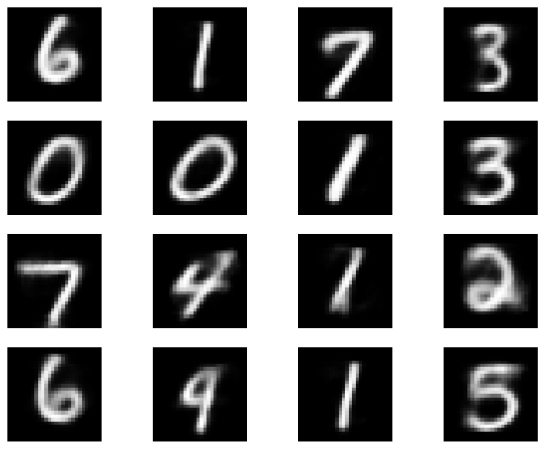

In [122]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Show images
def show_images(images):
    # sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    # print(sqrtn)
    for index, image in enumerate(images[:16]):
        plt.subplot(4,4, index+1)
        plt.imshow(image.reshape(28, 28))
        plt.axis('off')

# Load model

# model_ae = torch.load('AutoEncoder_MNIST4MSE.pth')
# model_ae.eval()
latent_dim_list = [64,32,4]


# Test
for x in range(len(latent_dim_list)):
    this_model = torch.load('AutoEncoder_MNIST'+str(latent_dim_list[x])+'MSE.pth')
    this_model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(train_loader):
            inputs = data.view(-1, 28*28)
            print('training dataset Original Images')
            show_images(inputs)
            plt.show()

            # Forward
            codes, outputs = this_model(inputs.to(device))
            outputs = outputs.detach().cpu()
            print('training dataset Restructured Image by AE latent_dim '+str(latent_dim_list[x])+' MSE')
            show_images(outputs)
            plt.show()
            if i==0:
                break

## Show 16 reconstructed image for 16 random images from testing dataset as a 4x4 grid

testing dataset Original Images


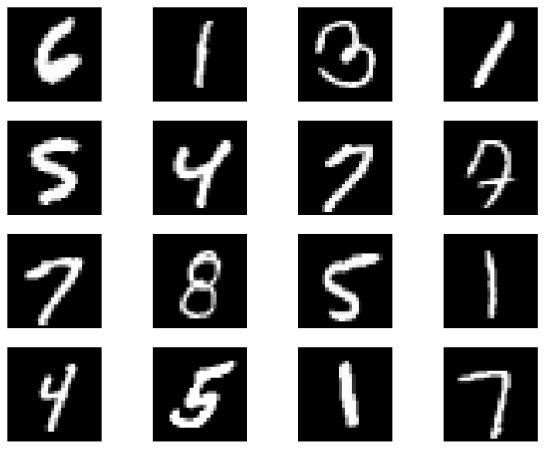

testing dataset Restructured Image by AE latent_dim 64 MSE


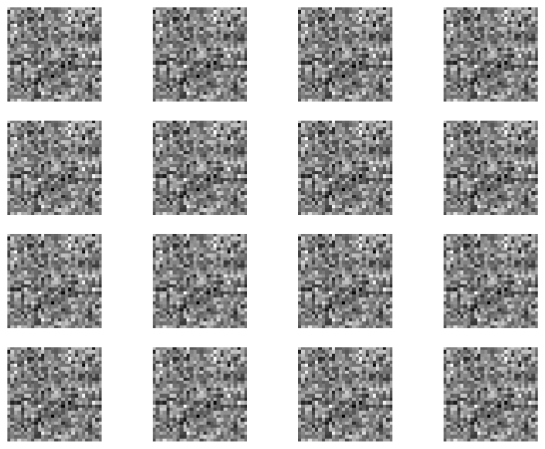

testing dataset Original Images


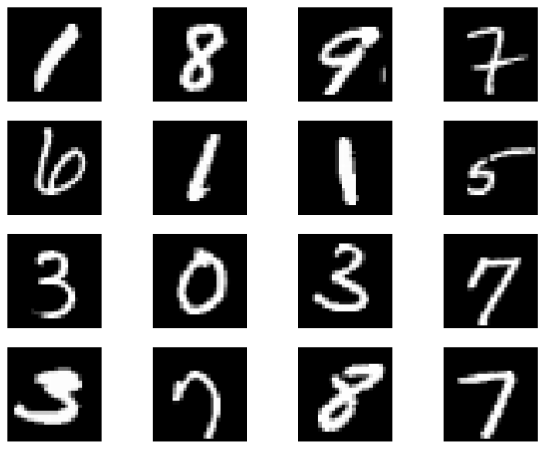

testing dataset Restructured Image by AE latent_dim 32 MSE


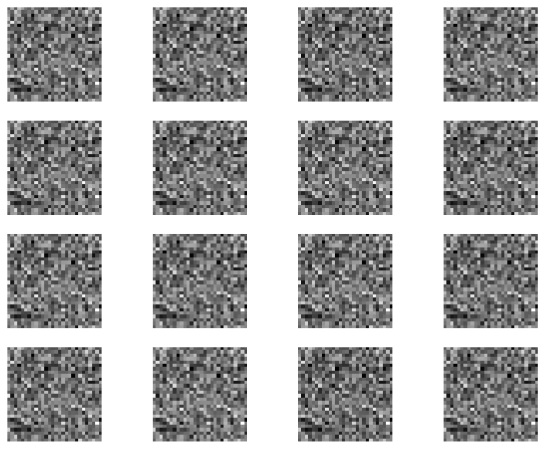

testing dataset Original Images


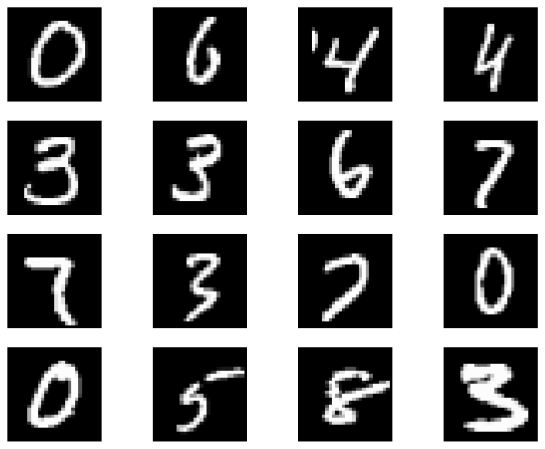

testing dataset Restructured Image by AE latent_dim 4 MSE


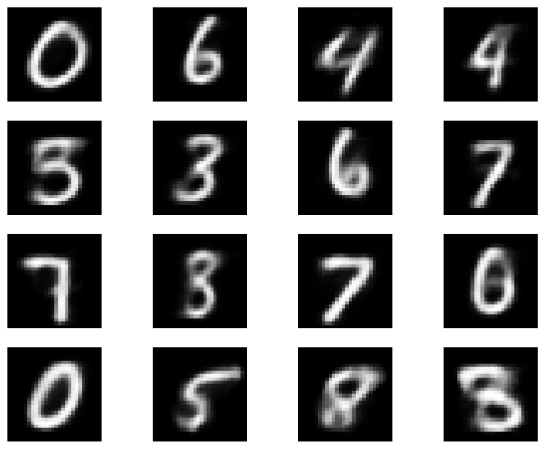

In [123]:

# Test
for x in range(len(latent_dim_list)):
    this_model = torch.load('AutoEncoder_MNIST'+str(latent_dim_list[x])+'MSE.pth')
    this_model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            inputs = data.view(-1, 28*28)
            print('testing dataset Original Images')
            show_images(inputs)
            plt.show()

            # Forward
            codes, outputs = this_model(inputs.to(device))
            outputs = outputs.detach().cpu()
            print('testing dataset Restructured Image by AE latent_dim '+str(latent_dim_list[x])+' MSE')
            show_images(outputs)
            plt.show()
            if i==0:
                break

## MNIST latent dim = 64,32,4 training and testing L1 Loss

In [124]:
epochs = 20
batch_size = 64
lr = 0.001
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
train_loader = DataLoader(datasets.MNIST('./MNIST', train=True, download=False, transform=transforms.ToTensor()), 
                          batch_size=batch_size, 
                          shuffle=True)
test_loader = DataLoader(datasets.MNIST('./MNIST', train=True, download=False, transform=transforms.ToTensor()), 
                          batch_size=batch_size, 
                          shuffle=True)
                          
latent_dim_list = [64,32,4]
model_ae = [0 for i in range(len(latent_dim_list))]
for i in range(len(latent_dim_list)):
    model_ae[i] = AutoEncoder(latent_dim_list[i]).to(device)
    optimizer = torch.optim.Adam(model_ae[i].parameters(), lr=lr)
    loss_function = nn.L1Loss().to(device)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,40], gamma=0.5)

In [125]:
for i in range(len(latent_dim_list)):
    # Train
    log_loss=[]
    model_ae[i].train()
    for epoch in range(epochs):
        total_loss = 0
        
        for data, _ in train_loader:
            inputs = data.view(-1, 784).to(device) 
            model_ae[i].zero_grad()
            # Forward
            codes, decoded = model_ae[i](inputs)
            loss = loss_function(decoded, inputs)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            log_loss.append(loss)
        total_loss /= len(train_loader.dataset)
        scheduler.step()

        # Test
        model_ae[i].eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                inputs = data.view(-1, 784).to(device)
                codes, decoded = model_ae[i](inputs)
                test_loss = loss_function(decoded, inputs)
                
        
        if epoch % 5 ==0:
            print('latent_dim',latent_dim_list[i],'[{}/{}] Train L1Loss:'.format(epoch+1, epochs), total_loss.item())
            print('latent_dim',latent_dim_list[i],'[{}/{}] Test L1Loss:'.format(epoch+1, epochs), test_loss.item())

        
    print('latent_dim',latent_dim_list[i],'[{}/{}] L1Loss:'.format(epoch+1, epochs), total_loss.item())
    print('latent_dim',latent_dim_list[i],'[{}/{}] Test L1Loss:'.format(epoch+1, epochs), test_loss.item())
    print('-----------------------------------------------------------------------------')
    # plt.plot(log_loss)
    torch.save(model_ae[i], 'AutoEncoder_MNIST'+str(latent_dim_list[i])+'L1.pth')

latent_dim 64 [1/20] Train L1Loss: 0.00738531444221735
latent_dim 64 [1/20] Test L1Loss: 0.4719475507736206
latent_dim 64 [6/20] Train L1Loss: 0.00738530931994319
latent_dim 64 [6/20] Test L1Loss: 0.47336098551750183
latent_dim 64 [11/20] Train L1Loss: 0.0073853228241205215
latent_dim 64 [11/20] Test L1Loss: 0.47322335839271545
latent_dim 64 [16/20] Train L1Loss: 0.007385309785604477
latent_dim 64 [16/20] Test L1Loss: 0.47184276580810547
latent_dim 64 [20/20] L1Loss: 0.007385312579572201
latent_dim 64 [20/20] Test L1Loss: 0.4723246693611145
-----------------------------------------------------------------------------
latent_dim 32 [1/20] Train L1Loss: 0.007386686746031046
latent_dim 32 [1/20] Test L1Loss: 0.4719994068145752
latent_dim 32 [6/20] Train L1Loss: 0.007386710494756699
latent_dim 32 [6/20] Test L1Loss: 0.47183170914649963
latent_dim 32 [11/20] Train L1Loss: 0.0073866937309503555
latent_dim 32 [11/20] Test L1Loss: 0.4712594449520111
latent_dim 32 [16/20] Train L1Loss: 0.007386

training dataset Original Images


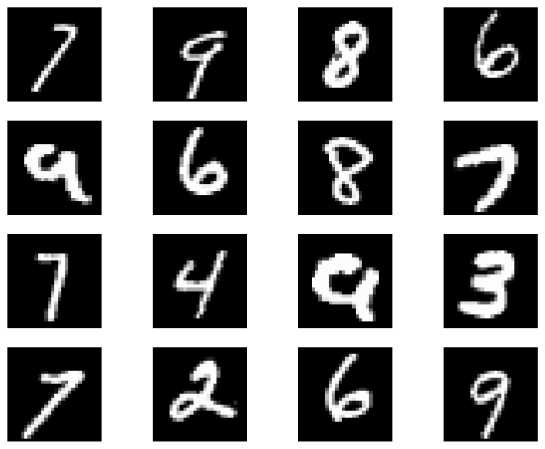

training dataset Restructured Image by AE latent_dim 64 L1


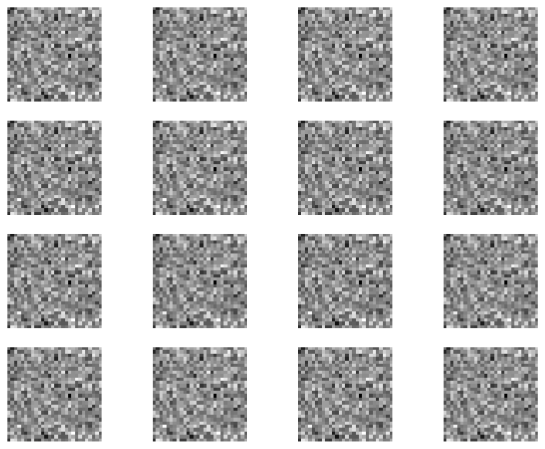

training dataset Original Images


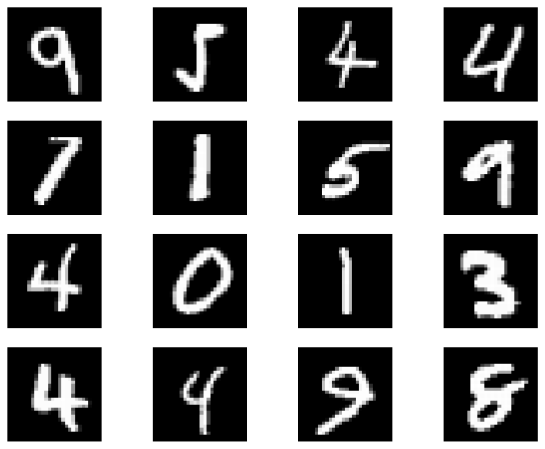

training dataset Restructured Image by AE latent_dim 32 L1


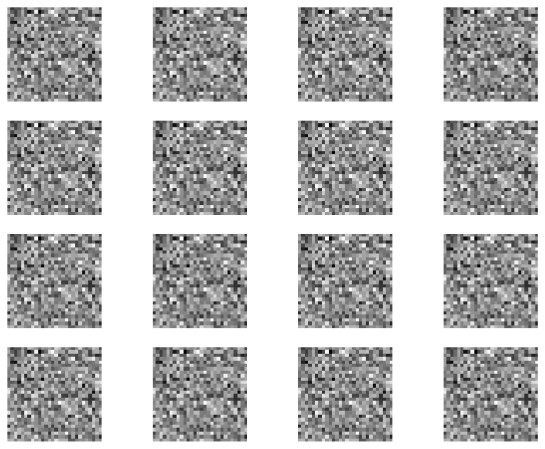

training dataset Original Images


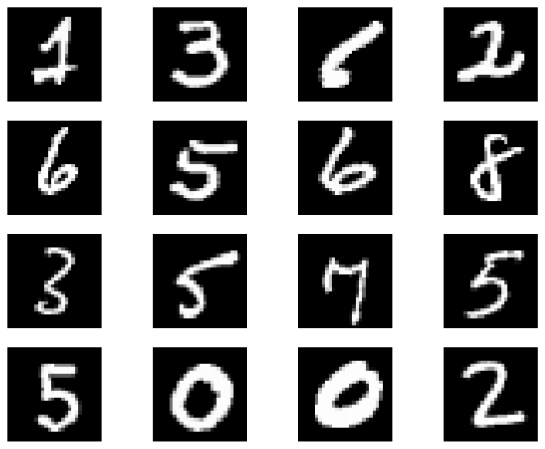

training dataset Restructured Image by AE latent_dim 4 L1


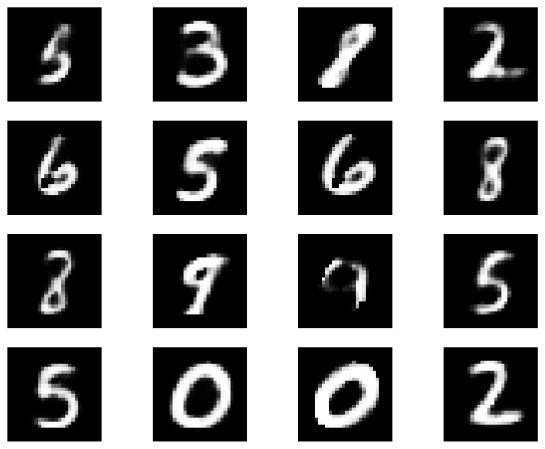

In [126]:


# Test
for x in range(len(latent_dim_list)):
    this_model = torch.load('AutoEncoder_MNIST'+str(latent_dim_list[x])+'L1.pth')
    this_model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(train_loader):
            inputs = data.view(-1, 28*28)
            print('training dataset Original Images')
            show_images(inputs)
            plt.show()

            # Forward
            codes, outputs = this_model(inputs.to(device))
            outputs = outputs.detach().cpu()
            print('training dataset Restructured Image by AE latent_dim '+str(latent_dim_list[x])+' L1')
            show_images(outputs)
            plt.show()
            if i==0:
                break

testing dataset Original Images


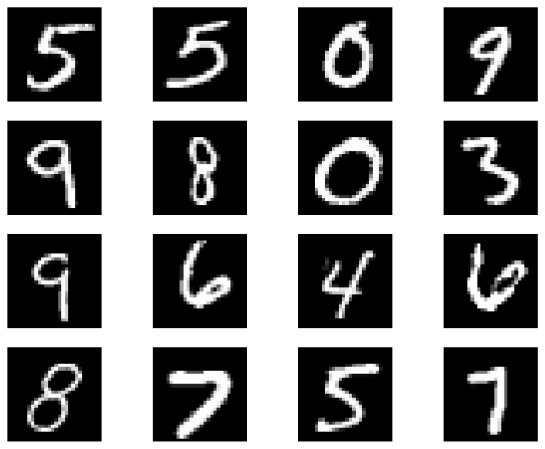

testing dataset Restructured Image by AE latent_dim 64 L1


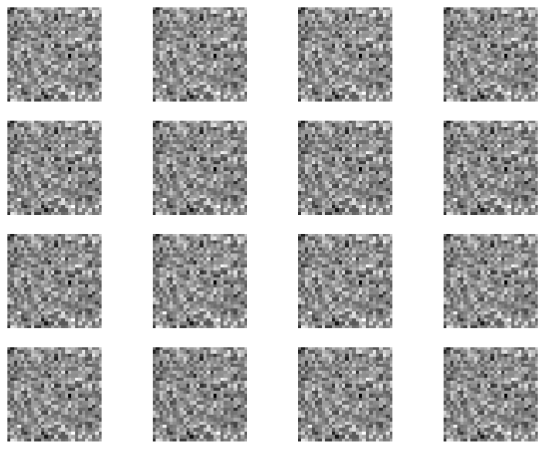

testing dataset Original Images


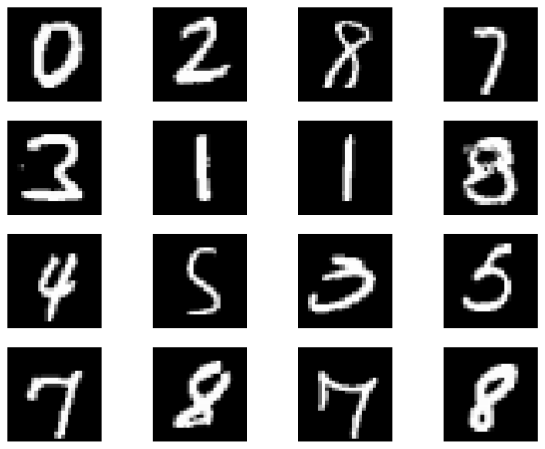

testing dataset Restructured Image by AE latent_dim 32 L1


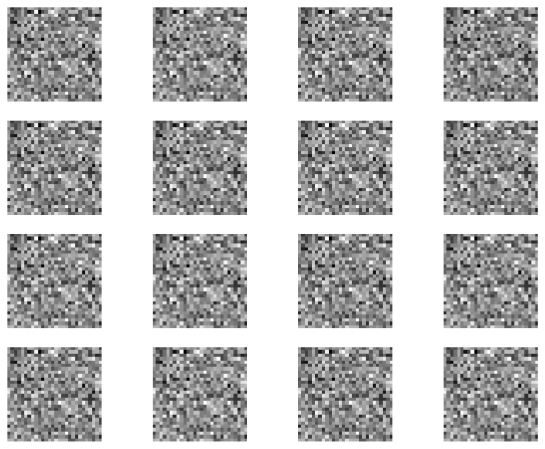

testing dataset Original Images


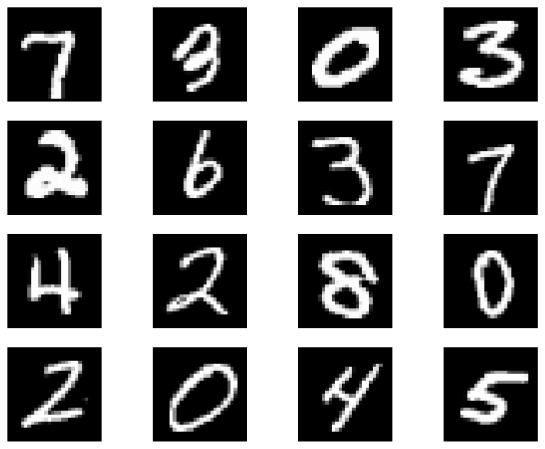

testing dataset Restructured Image by AE latent_dim 4 L1


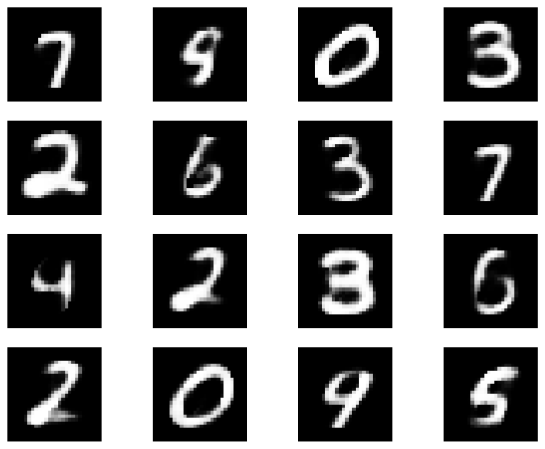

In [127]:

# Test
for x in range(len(latent_dim_list)):
    this_model = torch.load('AutoEncoder_MNIST'+str(latent_dim_list[x])+'L1.pth')
    this_model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            inputs = data.view(-1, 28*28)
            print('testing dataset Original Images')
            show_images(inputs)
            plt.show()

            # Forward
            codes, outputs = this_model(inputs.to(device))
            outputs = outputs.detach().cpu()
            print('testing dataset Restructured Image by AE latent_dim '+str(latent_dim_list[x])+' L1')
            show_images(outputs)
            plt.show()
            if i==0:
                break


## FashionMNIST latent dim = 64,32,4 training and testing MSE 

In [128]:

print('=============================================================================')  
print('FashionMNIST')

epochs = 20
batch_size = 64
lr = 0.001
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
train_loader = DataLoader(datasets.FashionMNIST('./FashionMNIST', train=True, download=False, transform=transforms.ToTensor()), 
                          batch_size=batch_size, 
                          shuffle=True)
test_loader = DataLoader(datasets.FashionMNIST('./FashionMNIST', train=True, download=False, transform=transforms.ToTensor()), 
                          batch_size=batch_size, 
                          shuffle=True)
                          
latent_dim_list = [64,32,4]
model_ae = [0 for i in range(len(latent_dim_list))]
for i in range(len(latent_dim_list)):
    model_ae[i] = AutoEncoder(latent_dim_list[i]).to(device)
    optimizer = torch.optim.Adam(model_ae[i].parameters(), lr=lr)
    loss_function = nn.MSELoss().to(device)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,40], gamma=0.5)
for i in range(len(latent_dim_list)):
    # Train
    log_loss=[]
    model_ae[i].train()
    for epoch in range(epochs):
        total_loss = 0
        
        for data, _ in train_loader:
            inputs = data.view(-1, 784).to(device) 
            model_ae[i].zero_grad()
            # Forward
            codes, decoded = model_ae[i](inputs)
            loss = loss_function(decoded, inputs)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            log_loss.append(loss)
        total_loss /= len(train_loader.dataset)
        scheduler.step()

        # Test
        model_ae[i].eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                inputs = data.view(-1, 784).to(device)
                codes, decoded = model_ae[i](inputs)
                test_loss = loss_function(decoded, inputs)
                
        
        if epoch % 5 ==0:
            print('latent_dim',latent_dim_list[i],'[{}/{}] Train MSELoss:'.format(epoch+1, epochs), total_loss.item())
            print('latent_dim',latent_dim_list[i],'[{}/{}] Test MSELoss:'.format(epoch+1, epochs), test_loss.item())

    
    print('latent_dim',latent_dim_list[i],'[{}/{}] MSELoss:'.format(epoch+1, epochs), total_loss.item())
    print('latent_dim',latent_dim_list[i],'[{}/{}] Test MSELoss:'.format(epoch+1, epochs), test_loss.item())
    print('-----------------------------------------------------------------------------')
    # plt.plot(log_loss)
    torch.save(model_ae[i], 'AutoEncoder_FashionMNIST'+str(latent_dim_list[i])+'MSE.pth')

    


FashionMNIST
latent_dim 64 [1/20] Train MSELoss: 0.002661920851096511
latent_dim 64 [1/20] Test MSELoss: 0.17167583107948303
latent_dim 64 [6/20] Train MSELoss: 0.002661945065483451
latent_dim 64 [6/20] Test MSELoss: 0.17069290578365326
latent_dim 64 [11/20] Train MSELoss: 0.002661909209564328
latent_dim 64 [11/20] Test MSELoss: 0.18467117846012115
latent_dim 64 [16/20] Train MSELoss: 0.0026617967523634434
latent_dim 64 [16/20] Test MSELoss: 0.17056916654109955
latent_dim 64 [20/20] MSELoss: 0.0026618128176778555
latent_dim 64 [20/20] Test MSELoss: 0.1854483187198639
-----------------------------------------------------------------------------
latent_dim 32 [1/20] Train MSELoss: 0.002669661771506071
latent_dim 32 [1/20] Test MSELoss: 0.18039172887802124
latent_dim 32 [6/20] Train MSELoss: 0.002669747918844223
latent_dim 32 [6/20] Test MSELoss: 0.15775097906589508
latent_dim 32 [11/20] Train MSELoss: 0.002669729758054018
latent_dim 32 [11/20] Test MSELoss: 0.16629639267921448
latent_dim

## Show 16 reconstructed image for 16 random images from training dataset as a 4x4 grid

training dataset Original Images


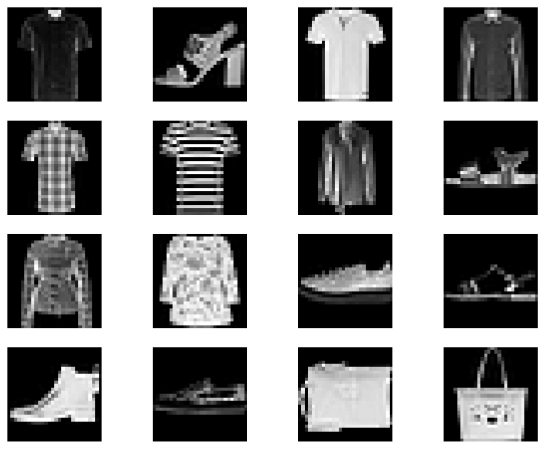

training dataset Restructured Image by AE latent_dim 64 MSE


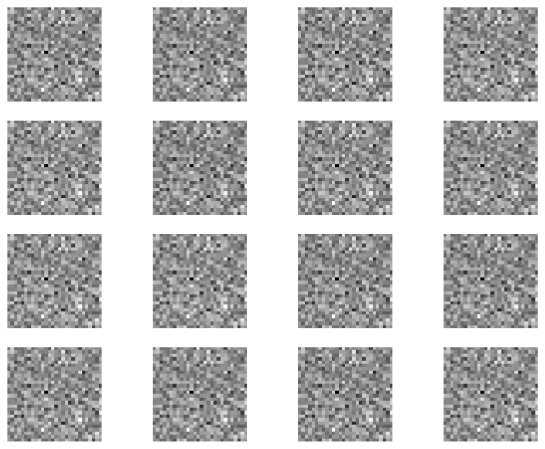

training dataset Original Images


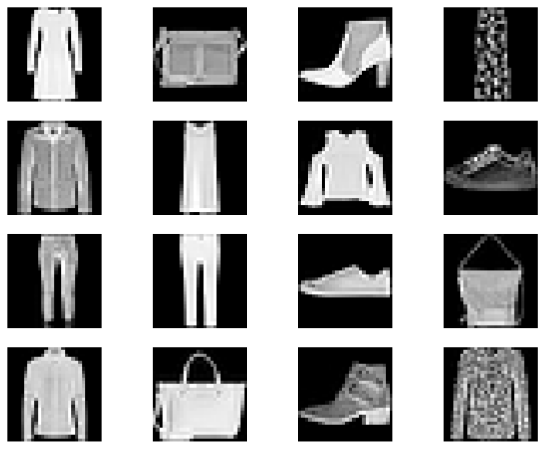

training dataset Restructured Image by AE latent_dim 32 MSE


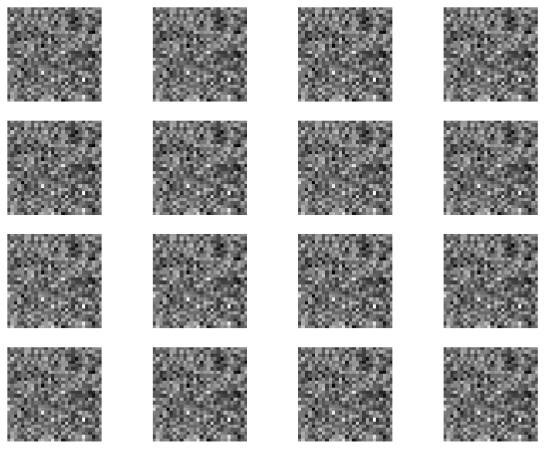

training dataset Original Images


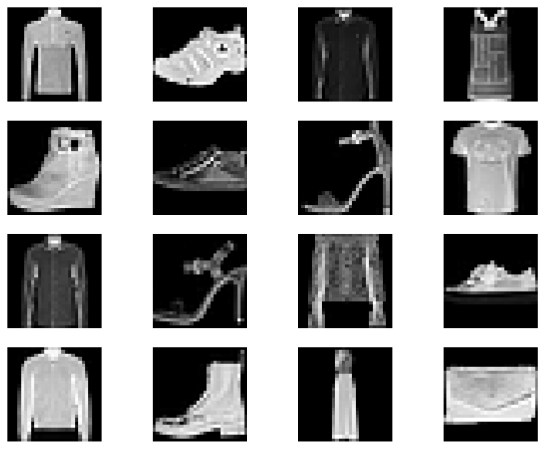

training dataset Restructured Image by AE latent_dim 4 MSE


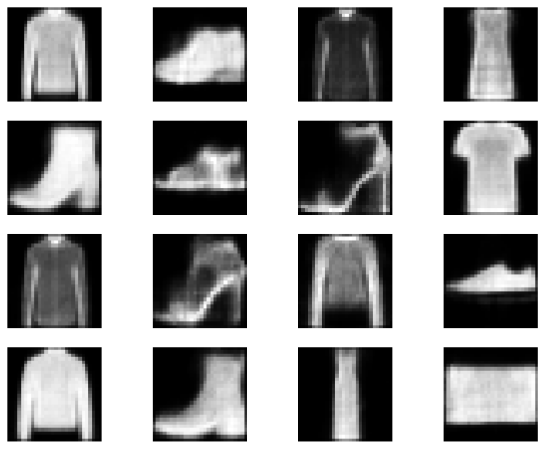

In [129]:

# Test
for x in range(len(latent_dim_list)):
    this_model = torch.load('AutoEncoder_FashionMNIST'+str(latent_dim_list[x])+'MSE.pth')
    this_model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(train_loader):
            inputs = data.view(-1, 28*28)
            print('training dataset Original Images')
            show_images(inputs)
            plt.show()

            # Forward
            codes, outputs = this_model(inputs.to(device))
            outputs = outputs.detach().cpu()
            print('training dataset Restructured Image by AE latent_dim '+str(latent_dim_list[x])+' MSE')
            show_images(outputs)
            plt.show()
            if i==0:
                break



## Show 16 reconstructed image for 16 random images from testing dataset as a 4x4 grid


testing dataset Original Images


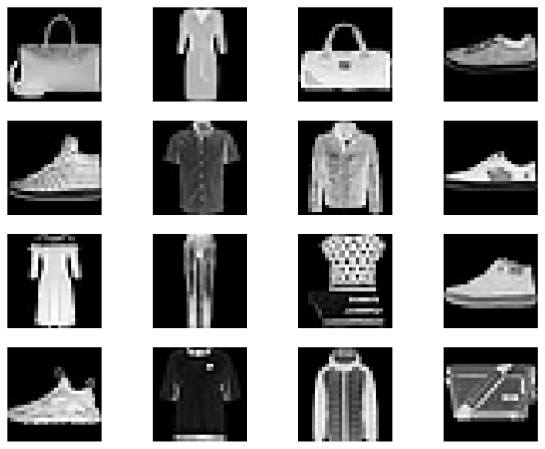

testing dataset Restructured Image by AE latent_dim 64 MSE


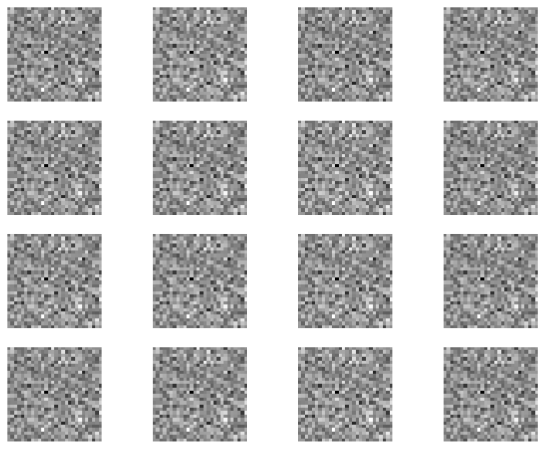

testing dataset Original Images


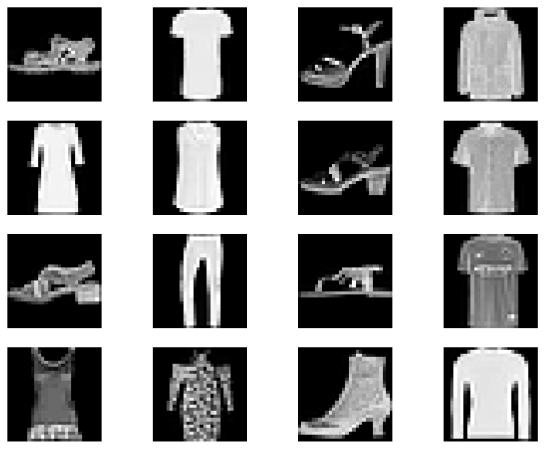

testing dataset Restructured Image by AE latent_dim 32 MSE


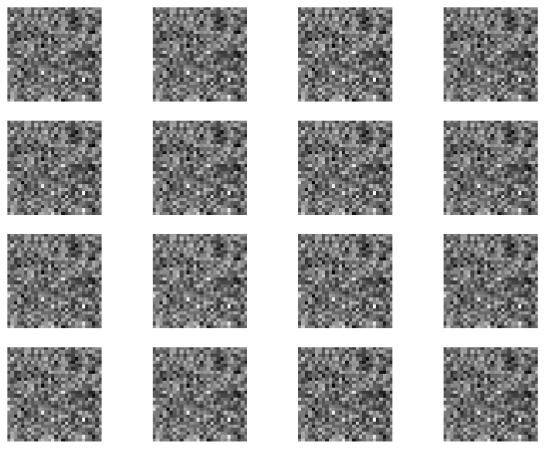

testing dataset Original Images


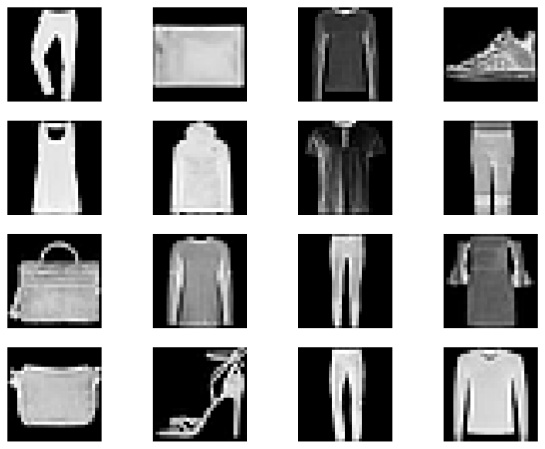

testing dataset Restructured Image by AE latent_dim 4 MSE


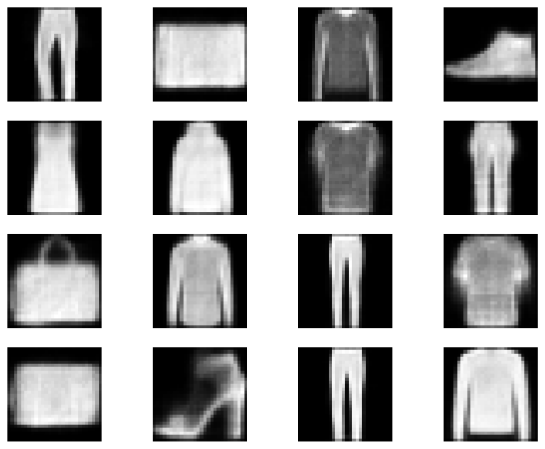

In [130]:

# Test
for x in range(len(latent_dim_list)):
    this_model = torch.load('AutoEncoder_FashionMNIST'+str(latent_dim_list[x])+'MSE.pth')
    this_model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            inputs = data.view(-1, 28*28)
            print('testing dataset Original Images')
            show_images(inputs)
            plt.show()

            # Forward
            codes, outputs = this_model(inputs.to(device))
            outputs = outputs.detach().cpu()
            print('testing dataset Restructured Image by AE latent_dim '+str(latent_dim_list[x])+' MSE')
            show_images(outputs)
            plt.show()
            if i==0:
                break

## FashionMNIST latent dim = 64,32,4 training and testing L1 Loss

In [131]:

epochs = 20
batch_size = 64
lr = 0.001
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
train_loader = DataLoader(datasets.FashionMNIST('./FashionMNIST', train=True, download=False, transform=transforms.ToTensor()), 
                          batch_size=batch_size, 
                          shuffle=True)
test_loader = DataLoader(datasets.FashionMNIST('./FashionMNIST', train=True, download=False, transform=transforms.ToTensor()), 
                          batch_size=batch_size, 
                          shuffle=True)
                          
latent_dim_list = [64,32,4]
model_ae = [0 for i in range(len(latent_dim_list))]
for i in range(len(latent_dim_list)):
    model_ae[i] = AutoEncoder(latent_dim_list[i]).to(device)
    optimizer = torch.optim.Adam(model_ae[i].parameters(), lr=lr)
    loss_function = nn.L1Loss().to(device)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,40], gamma=0.5)
for i in range(len(latent_dim_list)):
    # Train
    log_loss=[]
    model_ae[i].train()
    for epoch in range(epochs):
        total_loss = 0
        
        for data, _ in train_loader:
            inputs = data.view(-1, 784).to(device) 
            model_ae[i].zero_grad()
            # Forward
            codes, decoded = model_ae[i](inputs)
            loss = loss_function(decoded, inputs)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            log_loss.append(loss)
        total_loss /= len(train_loader.dataset)
        scheduler.step()

        # Test
        model_ae[i].eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                inputs = data.view(-1, 784).to(device)
                codes, decoded = model_ae[i](inputs)
                test_loss = loss_function(decoded, inputs)
                
        
        if epoch % 5 ==0:
            print('latent_dim',latent_dim_list[i],'[{}/{}] Train L1Loss:'.format(epoch+1, epochs), total_loss.item())
            print('latent_dim',latent_dim_list[i],'[{}/{}] Test L1Loss:'.format(epoch+1, epochs), test_loss.item())

        
    print('latent_dim',latent_dim_list[i],'[{}/{}] L1Loss:'.format(epoch+1, epochs), total_loss.item())
    print('latent_dim',latent_dim_list[i],'[{}/{}] Test L1Loss:'.format(epoch+1, epochs), test_loss.item())
    print('-----------------------------------------------------------------------------')
    # plt.plot(log_loss)
    torch.save(model_ae[i], 'AutoEncoder_FashionMNIST'+str(latent_dim_list[i])+'L1.pth')




latent_dim 64 [1/20] Train L1Loss: 0.005981723312288523
latent_dim 64 [1/20] Test L1Loss: 0.37607869505882263
latent_dim 64 [6/20] Train L1Loss: 0.005981581285595894
latent_dim 64 [6/20] Test L1Loss: 0.39147987961769104
latent_dim 64 [11/20] Train L1Loss: 0.005981719121336937
latent_dim 64 [11/20] Test L1Loss: 0.38462743163108826
latent_dim 64 [16/20] Train L1Loss: 0.0059816245920956135
latent_dim 64 [16/20] Test L1Loss: 0.3898860216140747
latent_dim 64 [20/20] L1Loss: 0.00598150584846735
latent_dim 64 [20/20] Test L1Loss: 0.3696291744709015
-----------------------------------------------------------------------------
latent_dim 32 [1/20] Train L1Loss: 0.005981807131320238
latent_dim 32 [1/20] Test L1Loss: 0.39668241143226624
latent_dim 32 [6/20] Train L1Loss: 0.005981710273772478
latent_dim 32 [6/20] Test L1Loss: 0.38153496384620667
latent_dim 32 [11/20] Train L1Loss: 0.005981738213449717
latent_dim 32 [11/20] Test L1Loss: 0.40238532423973083
latent_dim 32 [16/20] Train L1Loss: 0.0059

## Show 16 reconstructed image for 16 random images from training dataset as a 4x4 grid


training dataset Original Images


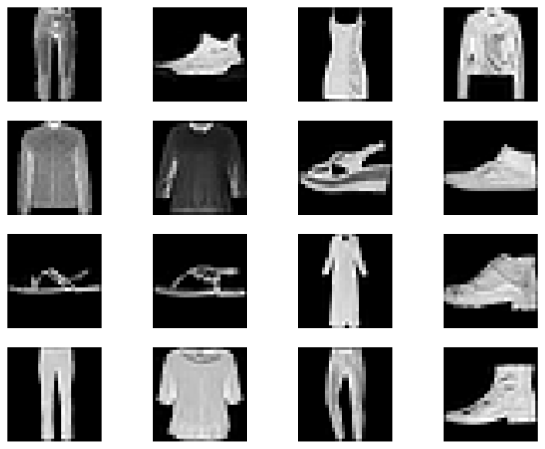

training dataset Restructured Image by AE latent_dim 64 L1


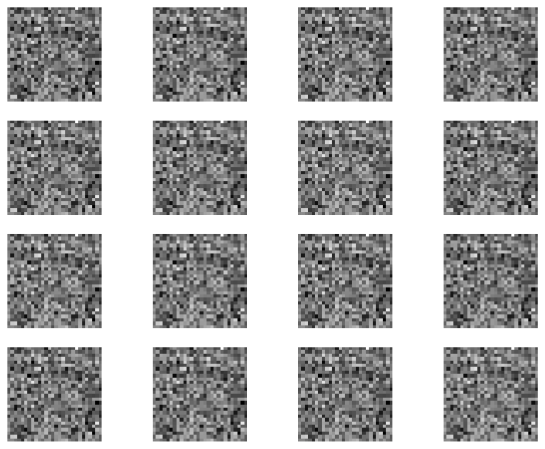

training dataset Original Images


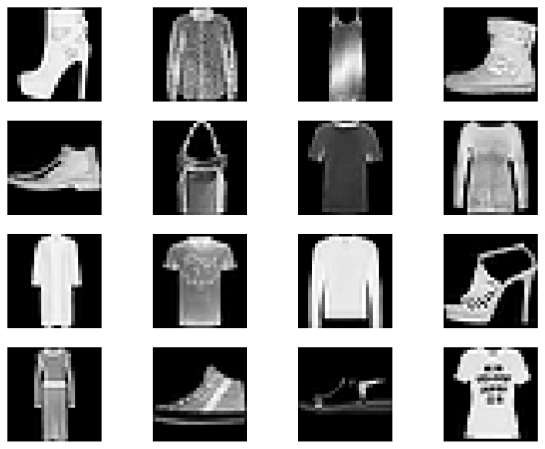

training dataset Restructured Image by AE latent_dim 32 L1


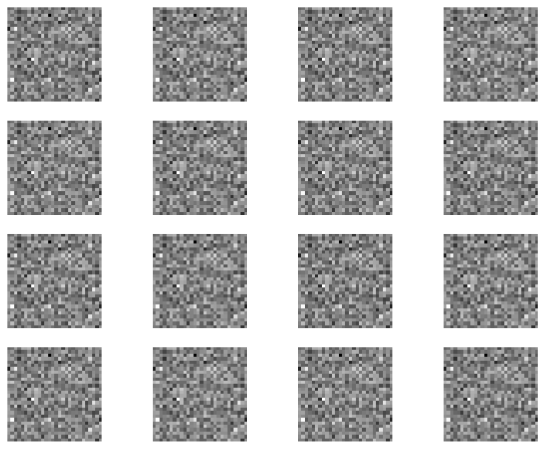

training dataset Original Images


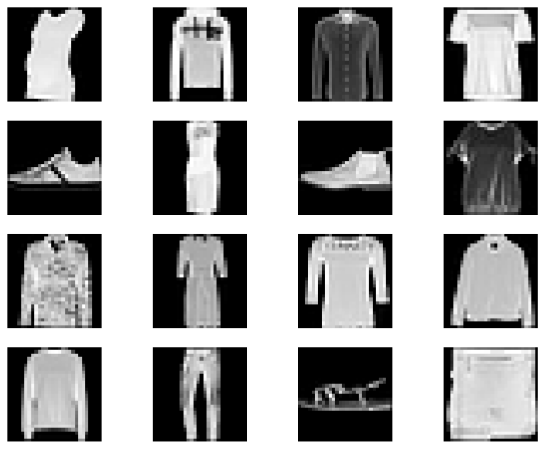

training dataset Restructured Image by AE latent_dim 4 L1


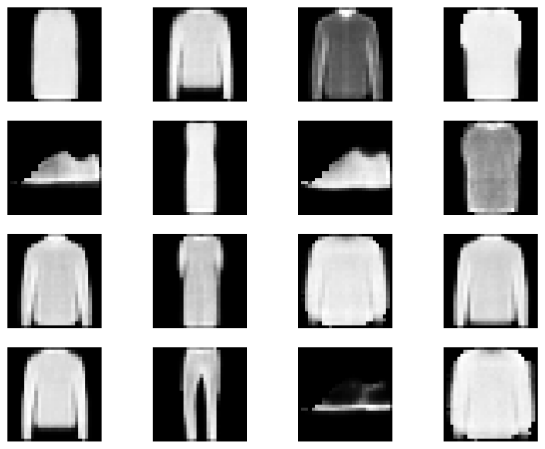

In [132]:
# Test
for x in range(len(latent_dim_list)):
    this_model = torch.load('AutoEncoder_FashionMNIST'+str(latent_dim_list[x])+'L1.pth')
    this_model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(train_loader):
            inputs = data.view(-1, 28*28)
            print('training dataset Original Images')
            show_images(inputs)
            plt.show()

            # Forward
            codes, outputs = this_model(inputs.to(device))
            outputs = outputs.detach().cpu()
            print('training dataset Restructured Image by AE latent_dim '+str(latent_dim_list[x])+' L1')
            show_images(outputs)
            plt.show()
            if i==0:
                break



## Show 16 reconstructed image for 16 random images from testing dataset as a 4x4 grid


testing dataset Original Images


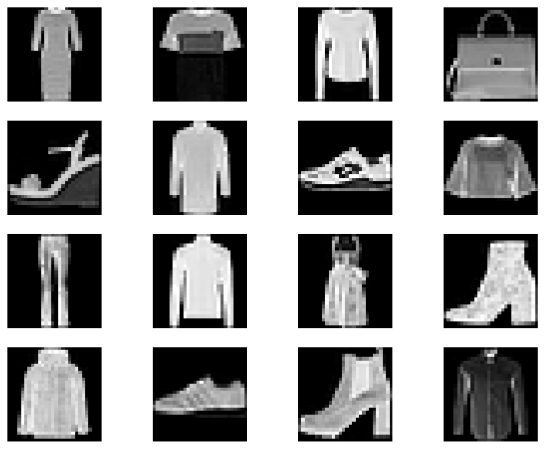

testing dataset Restructured Image by AE latent_dim 64 L1


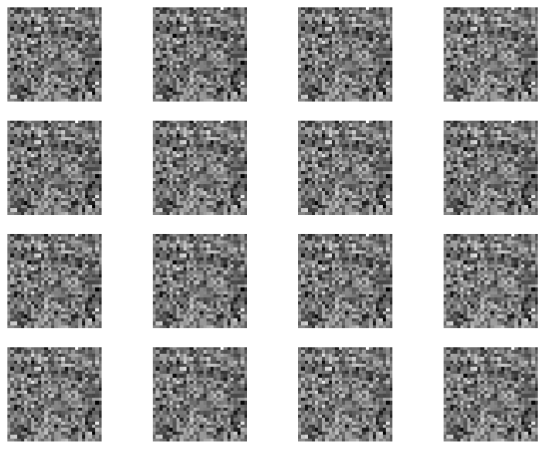

testing dataset Original Images


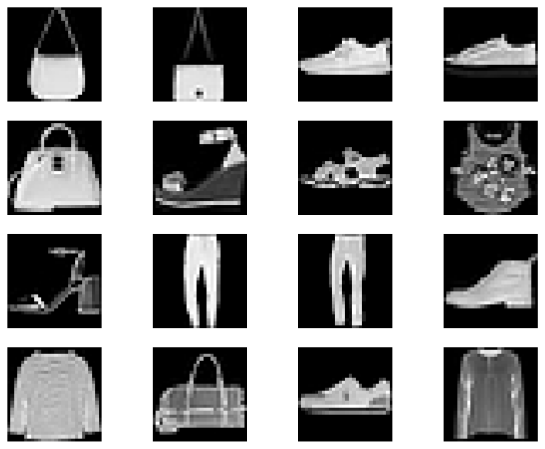

testing dataset Restructured Image by AE latent_dim 32 L1


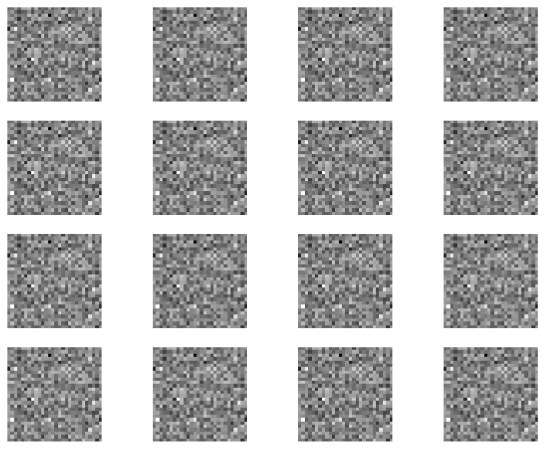

testing dataset Original Images


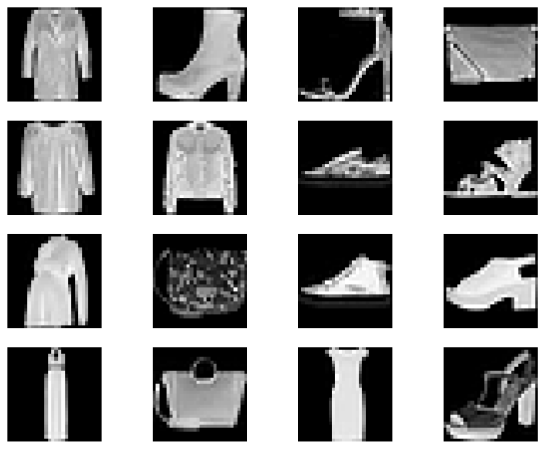

testing dataset Restructured Image by AE latent_dim 4 L1


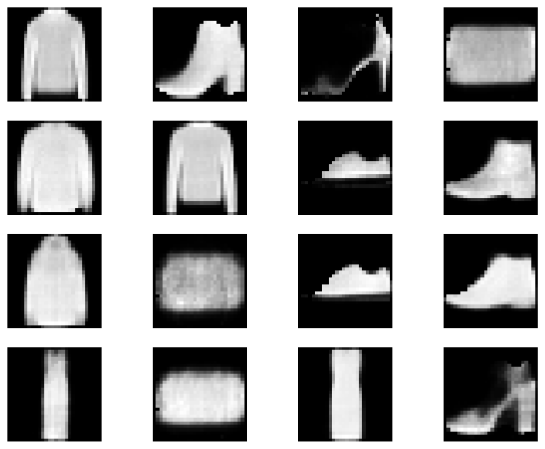

In [133]:

# Test
for x in range(len(latent_dim_list)):
    this_model = torch.load('AutoEncoder_FashionMNIST'+str(latent_dim_list[x])+'L1.pth')
    this_model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            inputs = data.view(-1, 28*28)
            print('testing dataset Original Images')
            show_images(inputs)
            plt.show()

            # Forward
            codes, outputs = this_model(inputs.to(device))
            outputs = outputs.detach().cpu()
            print('testing dataset Restructured Image by AE latent_dim '+str(latent_dim_list[x])+' L1')
            show_images(outputs)
            plt.show()
            if i==0:
                break